In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])


In [13]:
root = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/'

data_root = os.path.join(root, 'rb-compression-diffusion-lower-temp')

In [38]:
data = []
for root, dirs, files in os.walk(data_root):
    for dirname in dirs:
        if 'jamming_' in dirname:
            d = dp.data.load(os.path.join(root, dirname), location=['final', 'init'])
            if 'packing_fraction' not in d.final.arrays.keys():
                continue
            d.calculate_mu_eff()
            data.append(d)

In [39]:
nv = np.concatenate([d.n_vertices_per_particle[d.system_offset[:-1]] for d in data])
mu = np.concatenate([d.mu_eff[d.system_offset[:-1]] for d in data])
nv_mu_vals = np.unique(np.column_stack((nv, mu)), axis=0)

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_10919/2037149787.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(d.init.packing_fraction[i], d.final.packing_fraction[i], c=cmap(mu_norm(_mu_i)))


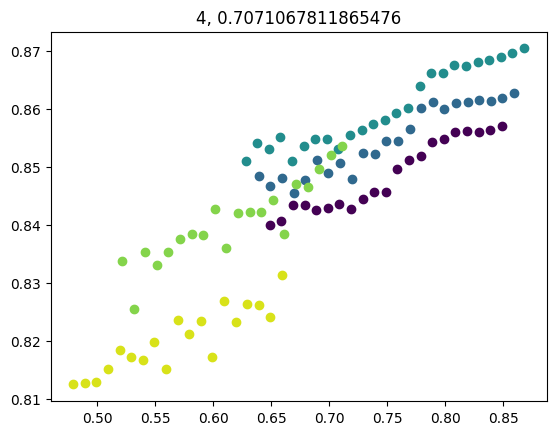

In [57]:
mu_norm = LogNorm(vmin=min(mu), vmax=max(mu))
cmap = plt.cm.viridis

d_plot = None

for _nv in np.unique(nv):
    for _mu in np.unique(mu[nv == _nv]):
        for d in data:
            for i, (_nv_i, _mu_i) in enumerate(zip(d.n_vertices_per_particle[d.system_offset[:-1]], d.mu_eff[d.system_offset[:-1]])):
                if _nv_i != _nv or _mu_i != _mu:
                    continue
                if d.final.pe_total[i] / d.system_size[i] > 1e-14:
                    continue
                d_plot = d
                plt.scatter(d.init.packing_fraction[i], d.final.packing_fraction[i], c=cmap(mu_norm(_mu_i)))
    plt.title(f'{_nv}, {_mu}')
    break
    plt.show()

(10.0, 12.0)

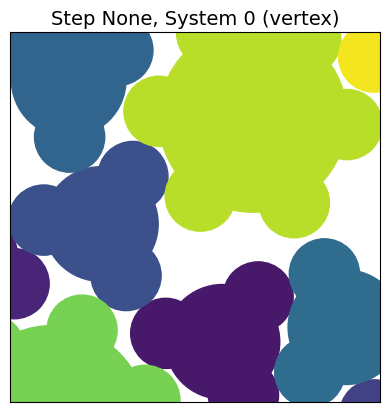

In [60]:
draw_particles_frame(None, plt.gca(), d_plot, 0, True, 'vertex', 'viridis', None)
plt.xlim(10, 12)
plt.ylim(10, 12)